In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [3]:
from sklearn.preprocessing import StandardScaler

In [5]:
# Standardize 'Amount' and 'Time'
scaler = StandardScaler()
df["scaled_amount"] = scaler.fit_transform(df[["Amount"]])
df["scaled_time"] = scaler.fit_transform(df[["Time"]])

In [6]:
df.drop(["Time", "Amount"], axis=1, inplace=True)

# Reorder columns
scaled_cols = ["scaled_amount", "scaled_time"]
others = [col for col in df.columns if col not in scaled_cols + ["Class"]]
df = df[scaled_cols + others + ["Class"]]

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.329267,-1.722139,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.0
1,-0.339668,-1.722139,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.0
2,1.372029,-1.722055,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.0
3,0.210349,-1.722055,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.0
4,-0.033268,-1.721971,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.0


In [8]:
df = df.dropna(subset=["Class"])


In [9]:
from sklearn.model_selection import train_test_split


#Define features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# 📤 Split dataset (stratified to keep class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

In [11]:
from imblearn.over_sampling import SMOTE

In [12]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_res))

Before SMOTE: [19407    65]
After SMOTE: [19407 19407]


In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf.fit(X_res, y_res)

# Predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

In [14]:
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\n Evaluation for: {name}")
    print(" Accuracy:", round(accuracy_score(y_true, y_pred) * 100, 2), "%")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print(" Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print(" ROC AUC Score:", round(roc_auc_score(y_true, y_proba), 4))

In [15]:
evaluate_model("Original Logistic Regression", y_test, y_pred_lr, y_proba_lr)
evaluate_model("Optimized Random Forest (SMOTE)", y_test, y_pred_rf, y_proba_rf)


 Evaluation for: Original Logistic Regression
 Accuracy: 98.8 %
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9995    0.9885    0.9940      8318
         1.0     0.2000    0.8571    0.3243        28

    accuracy                         0.9880      8346
   macro avg     0.5998    0.9228    0.6591      8346
weighted avg     0.9968    0.9880    0.9917      8346

 Confusion Matrix:
[[8222   96]
 [   4   24]]
 ROC AUC Score: 0.9605

 Evaluation for: Optimized Random Forest (SMOTE)
 Accuracy: 99.92 %
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9995    0.9996    0.9996      8318
         1.0     0.8889    0.8571    0.8727        28

    accuracy                         0.9992      8346
   macro avg     0.9442    0.9284    0.9362      8346
weighted avg     0.9991    0.9992    0.9992      8346

 Confusion Matrix:
[[8315    3]
 [   4   24]]
 ROC AUC Score: 0.9613


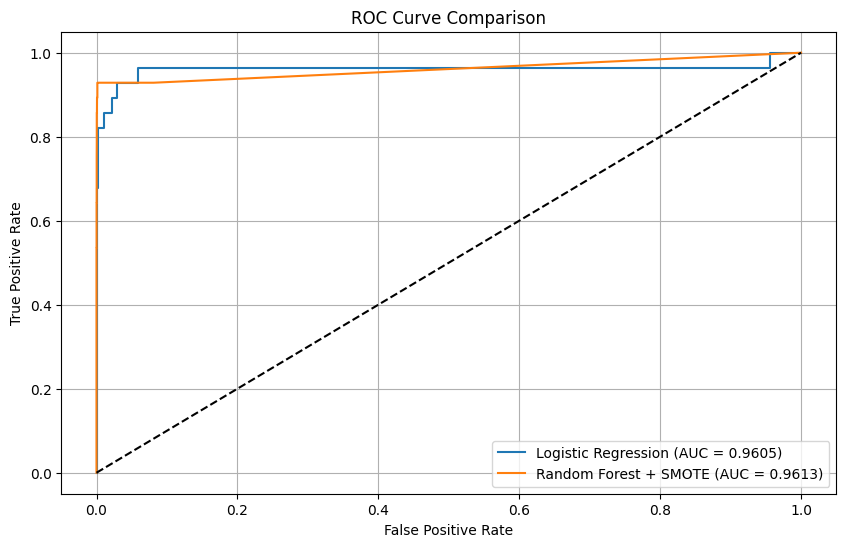

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression (AUC = %.4f)" % roc_auc_score(y_test, y_proba_lr))
plt.plot(fpr_rf, tpr_rf, label="Random Forest + SMOTE (AUC = %.4f)" % roc_auc_score(y_test, y_proba_rf))
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()